In [1]:
import tupak
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 12]

12:09 tupak INFO    : Running tupak version: 0.2.1 - (UNCLEAN) 55629c6 2018-07-18 08:35:37 +1000


## Define the model to fit to the data

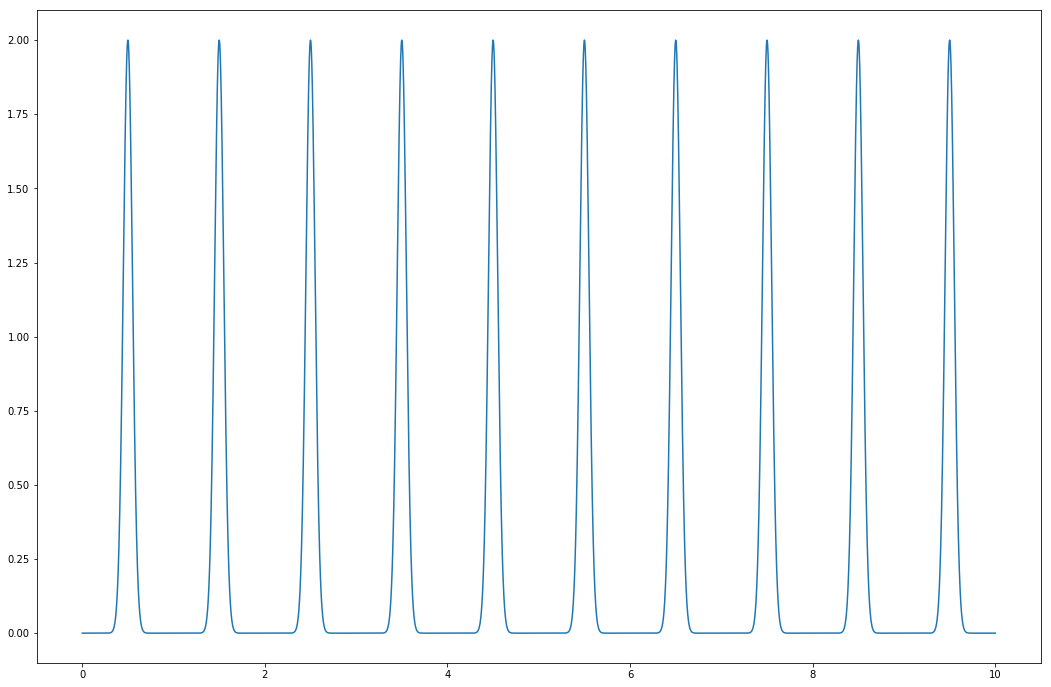

In [2]:
def periodic_gaussian(time, amplitude, period, width, phase, **kwargs):
    return amplitude * np.exp(-(np.mod(time+phase*period, period)-period/2.)**2 / width**2 / 2)

time = np.linspace(0, 10, 10000)
y = periodic_gaussian(time, 2, 1, 0.05, 0)
plt.plot(time, y)
plt.show()

## Load in the data and plot

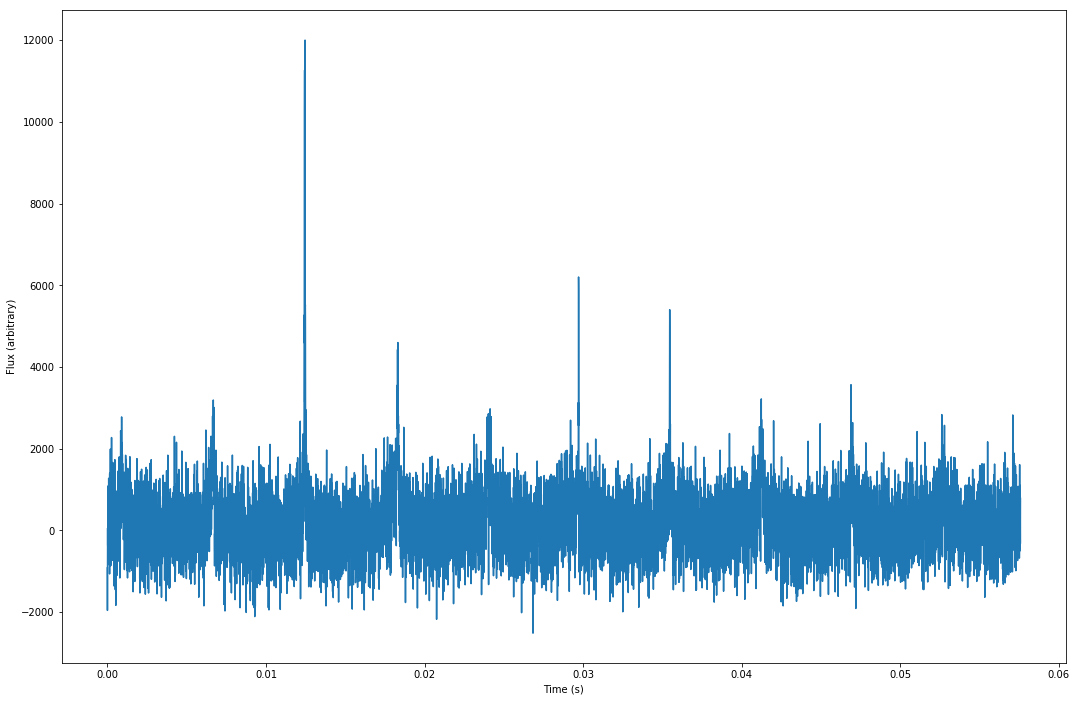

In [3]:
real_period = 0.00575770575112002
real_width = 0.00004 

# let's get the first 100 profiles:
data = np.load("1minute_r05.npy")
data_flat = data.flatten()
data_flat_short = data_flat[0:1024*10]
time = np.linspace(0, 10 * real_period, 1024*10)

plt.plot(time, data_flat_short)
plt.xlabel('Time (s)')
plt.ylabel('Flux (arbitrary)')
plt.show()

## Parameter estimation with tupak

12:09 tupak INFO    : Search parameters:
12:09 tupak INFO    :   phase = Uniform(name='phase', latex_label='$\\phi$', minimum=0, maximum=1)
12:09 tupak INFO    :   width = Uniform(name='width', latex_label='width', minimum=0, maximum=0.1)
12:09 tupak INFO    :   sigma = Uniform(name='sigma', latex_label='sigma', minimum=0, maximum=1000)
12:09 tupak INFO    :   period = Uniform(name='period', latex_label='period', minimum=0.0051819351760080175, maximum=0.006333476326232022)
12:09 tupak INFO    :   amplitude = Uniform(name='amplitude', latex_label='amplitude', minimum=0, maximum=5000)
12:09 tupak INFO    : Single likelihood evaluation took 5.290e-04 s
12:09 tupak INFO    : Using sampler Ptemcee with kwargs {'nburn': 500, 'ntemps': 3, 'nsteps': 2000}
100%|██████████| 2000/2000 [05:34<00:00,  5.98it/s]
12:14 tupak INFO    : Max autocorr time = 95.7534866959
12:14 tupak INFO    : Tswap frac = [0.14135 0.13307 0.12479]
12:14 tupak INFO    : Sampling time: 0:05:34.729935
12:14 tupak INFO    :

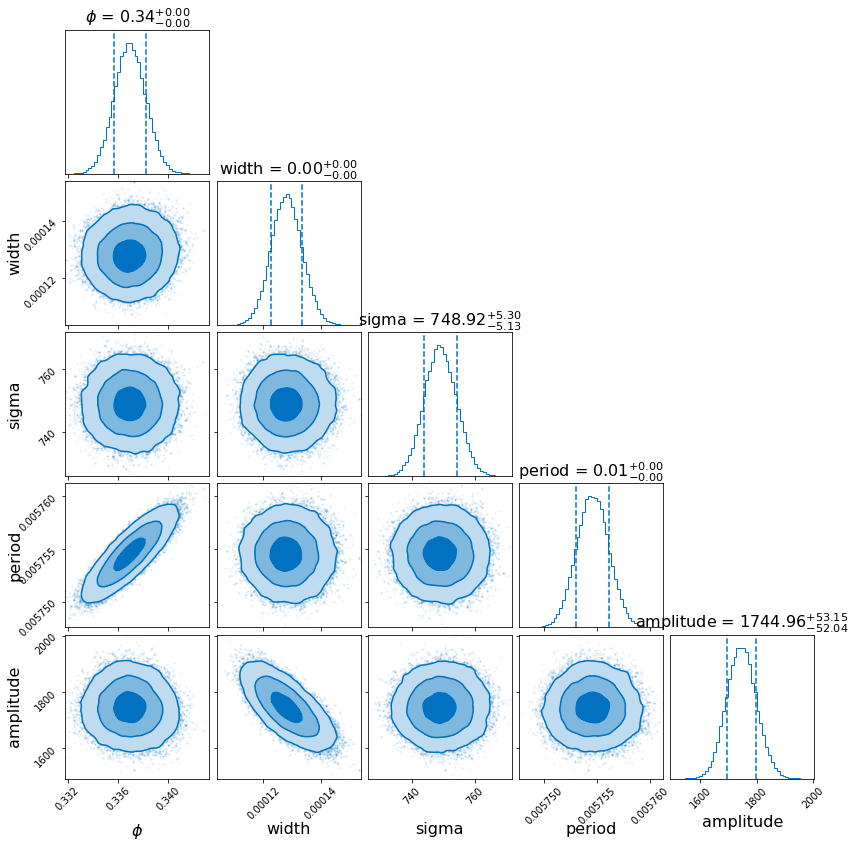

In [4]:
likelihood = tupak.core.likelihood.GaussianLikelihood(x=time, y=data_flat_short, function=periodic_gaussian)

priors = dict()
priors['amplitude'] = tupak.prior.Uniform(0, 5000, 'amplitude')
priors['width'] = tupak.prior.Uniform(0, 1e-1, 'width')
priors['period'] = tupak.prior.Uniform(real_period-0.1*real_period, real_period+0.1*real_period, 'period')
priors['phase'] = tupak.prior.Uniform(0, 1, 'phase')
priors['sigma'] = tupak.prior.Uniform(0, 1000, 'sigma')

result = tupak.sampler.run_sampler(likelihood=likelihood, priors=priors, sampler='ptemcee', 
                                   nsteps=2000, nburn=500, ntemps=3, clean=True)
result.plot_corner()
plt.show()

## Plot the data with 100 draws from the posterior

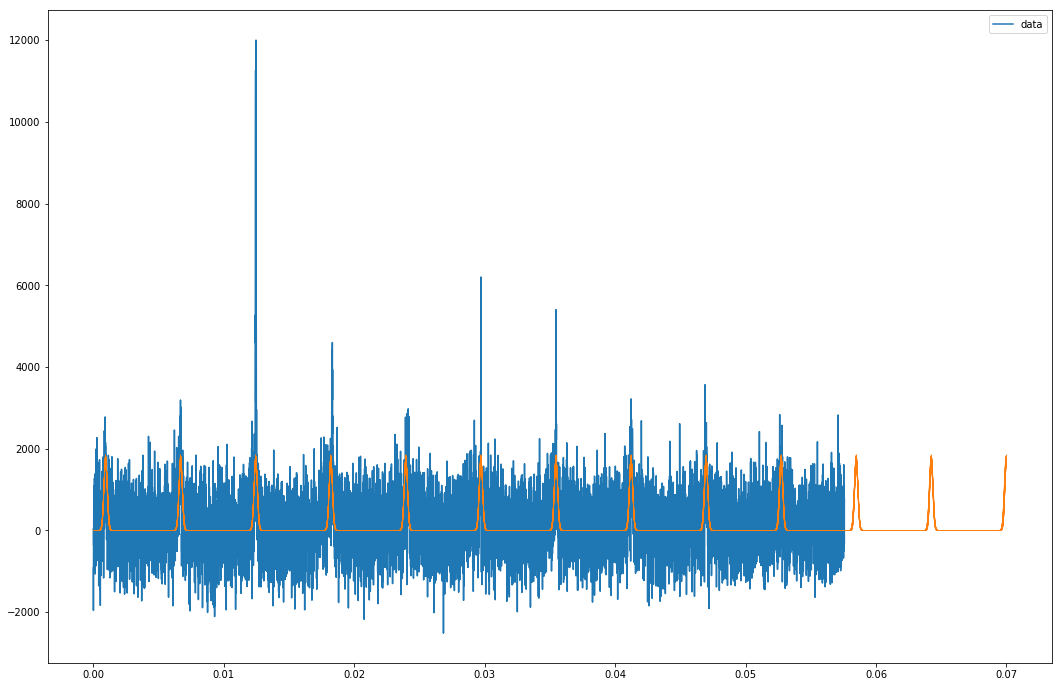

In [5]:
plt.plot(time, data_flat_short, label='data')

time_smooth = np.linspace(0, 0.07, 10000)
for i in range(100):
    params = result.posterior.sample().iloc[0].to_dict()
    plt.plot(time_smooth, periodic_gaussian(time_smooth, **params),
             'C1', lw=0.5)
    
plt.legend()
plt.show()